In [1]:
# /*==========================================================================================*\
# **                        _           _ _   _     _  _         _                            **
# **                       | |__  _   _/ | |_| |__ | || |  _ __ | |__                         **
# **                       | '_ \| | | | | __| '_ \| || |_| '_ \| '_ \                        **
# **                       | |_) | |_| | | |_| | | |__   _| | | | | | |                       **
# **                       |_.__/ \__,_|_|\__|_| |_|  |_| |_| |_|_| |_|                       **
# \*==========================================================================================*/


# -----------------------------------------------------------------------------------------------
# Author: Bùi Tiến Thành (@bu1th4nh)
# Title: BRCA.ipynb
# Date: 2024/09/12 13:56:42
# Description: Pre-process the data for the Breast Cancer dataset, Cross-omics setting
# 
# (c) bu1th4nh. All rights reserved
# Written with dedication in the University of Central Florida, EPCOT and the Magic Kingdom.
# -----------------------------------------------------------------------------------------------


import s3fs
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Union, Literal
import ydata_profiling as ydp
import matplotlib.pyplot as plt
import os



# DATA_PATH = '/home/ti514716/Datasets/BreastCancer'
# storage_options = None
# s3 = None

TEST_PASS = 100
OVERRIDE_EXISTING_2_OMICS = False
OVERRIDE_EXISTING_3_OMICS = False




DATA_PATH = 's3://datasets/BreastCancer'
storage_options = {
    'key': 'bu1th4nh',
    'secret': 'ariel.anna.elsa',
    'endpoint_url': 'http://localhost:9000',
}
s3 = s3fs.S3FileSystem(
    key=storage_options['key'],
    secret=storage_options['secret'],
    endpoint_url=storage_options['endpoint_url'],
    use_ssl=False,
)

/home/ti514716/Venvs/CrossOmics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parquet-ize the data
parquetize = False
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/raw_parquet'):
        s3.makedirs(f'{DATA_PATH}/raw_parquet')
        parquetize = True
else:
    if not os.path.exists(f'{DATA_PATH}/raw_parquet'):
        os.makedirs(f'{DATA_PATH}/raw_parquet')
        parquetize = True


if parquetize:
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/bipartite_targetscan_gene.csv', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/bipartite_targetscan_gene.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/brca_clinical.csv', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/brca_clinical.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/brca_tcga_clinical_data.tsv', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/brca_survival.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/DNAMethyl_BRCA_450k', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/methDNA.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/miRNA.csv', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/miRNA.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/mRNA.csv', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/mRNA.parquet', storage_options=storage_options)


# Data Acquisition

In [3]:
raw_bipart_data = pd.read_parquet(f'{DATA_PATH}/raw_parquet/bipartite_targetscan_gene.parquet', storage_options=storage_options)
raw_clinical = pd.read_parquet(f'{DATA_PATH}/raw_parquet/brca_clinical.parquet', storage_options=storage_options)
raw_survival = pd.read_parquet(f'{DATA_PATH}/raw_parquet/brca_survival.parquet', storage_options=storage_options)
raw_methDNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/methDNA.parquet', storage_options=storage_options)
raw_miRNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/miRNA.parquet', storage_options=storage_options)
raw_mRNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/mRNA.parquet', storage_options=storage_options)

# Elementary Data Analysis

### mRNA, miRNA, and methylation data

In [5]:
# Sampling
display(raw_mRNA.head())
display(raw_miRNA.head())
display(raw_methDNA.head())

,sample,TCGA-AR-A5QQ-01,TCGA-D8-A1JA-01,TCGA-BH-A0BQ-01,TCGA-BH-A0BT-01,TCGA-A8-A06X-01,TCGA-A8-A096-01,TCGA-BH-A0C7-01,TCGA-AC-A5XU-01,TCGA-PE-A5DE-01,...,TCGA-A7-A13E-11,TCGA-C8-A8HP-01,TCGA-E9-A5FL-01,TCGA-AC-A2FB-11,TCGA-E2-A15F-01,TCGA-A2-A3XT-01,TCGA-B6-A0X7-01,TCGA-BH-A1EV-11,TCGA-3C-AALJ-01,TCGA-B6-A0X1-01
0,ARHGEF10L,9.5074,7.4346,9.3216,9.0198,9.6417,9.7665,10.0931,9.1524,9.9398,...,9.6265,10.1826,9.9199,9.9090,10.0334,11.5144,10.5745,9.4048,10.9468,10.3164
1,HIF3A,1.5787,3.6607,2.7224,1.3414,0.5819,0.2738,3.6090,0.4738,2.9378,...,8.1546,2.2159,3.8645,8.1872,0.8836,1.3169,4.0696,7.2537,0.9310,2.4191
2,RNF17,0.0000,0.6245,0.5526,0.0000,0.0000,0.8765,0.0000,0.0000,0.0000,...,0.0000,0.0000,3.7305,0.0000,0.0000,1.1329,0.4258,0.0000,0.0000,0.0000
3,RNF10,11.3676,11.9181,11.9665,13.1881,12.0036,11.8118,11.3820,11.5004,12.2055,...,11.9869,12.2653,12.4815,11.8263,12.0135,11.5818,11.8663,11.5460,12.2616,12.1570
4,RNF11,11.1292,13.5273,11.4105,11.0911,11.2545,10.8554,10.7663,10.4358,11.2210,...,11.9344,11.4117,10.4902,11.5754,10.8370,10.2736,10.7644,11.8774,10.7842,11.2420


,sample,TCGA-OL-A66H-01,TCGA-3C-AALK-01,TCGA-AR-A1AH-01,TCGA-AC-A5EH-01,TCGA-EW-A2FW-01,TCGA-E9-A1R0-01,TCGA-BH-A0BL-01,TCGA-AR-A1AJ-01,TCGA-A7-A13G-01,...,TCGA-E2-A574-01,TCGA-E2-A1IG-01,TCGA-5L-AAT0-01,TCGA-E9-A1NH-01,TCGA-EW-A6SA-01,TCGA-AR-A24Q-01,TCGA-BH-A1F0-01,TCGA-E9-A1RB-11,TCGA-GM-A4E0-01,TCGA-AC-A5XU-01
0,MIMAT0019868,0.2381,NaN,NaN,NaN,0.1951,NaN,NaN,0.4831,0.537604,...,NaN,NaN,NaN,0.709,NaN,NaN,NaN,NaN,NaN,NaN
1,MIMAT0019869,NaN,0.2117,NaN,NaN,0.1951,0.6706,NaN,NaN,NaN,...,NaN,NaN,0.348594,NaN,NaN,NaN,0.7569,0.1298,NaN,NaN
2,MIMAT0019860,NaN,NaN,NaN,NaN,NaN,NaN,0.403,0.4831,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MIMAT0019862,NaN,NaN,NaN,NaN,0.1951,NaN,NaN,NaN,NaN,...,NaN,0.4285,NaN,NaN,0.3034,0.5908,0.7569,NaN,NaN,0.2444
4,MIMAT0019863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,sample,TCGA-OL-A66H-01,TCGA-3C-AALK-01,TCGA-AC-A5EH-01,TCGA-EW-A2FW-01,TCGA-E9-A1R0-01,TCGA-AR-A1AJ-01,TCGA-AC-A62Y-01,TCGA-E9-A1QZ-01,TCGA-E9-A1R2-01,...,TCGA-BH-A0DI-01,TCGA-E2-A1IG-01,TCGA-E2-A107-01,TCGA-5L-AAT0-01,TCGA-E9-A1NH-01,TCGA-D8-A27E-01,TCGA-AR-A24Q-01,TCGA-BH-A1F0-01,TCGA-E9-A1RB-11,TCGA-AR-A0U0-01
0,cg13332474,0.0192,0.2032,0.3003,0.0287,0.0382,0.0426,0.0240,0.2907,0.0293,...,0.0481,0.0263,0.5187,0.0757,0.0458,0.0309,0.0412,0.0452,0.0492,0.0445
1,cg00651829,0.0179,0.2890,0.0892,0.0234,0.0260,0.0310,0.0228,0.0255,0.0221,...,0.0247,0.0166,0.0154,0.0420,0.0262,0.0273,0.0247,0.0214,0.0247,0.0192
2,cg17027195,0.0367,0.0750,0.0333,0.0460,0.0411,0.1116,0.0386,0.0372,0.0384,...,0.0765,0.0415,0.0595,0.0664,0.0370,0.0665,0.0387,0.0663,0.0425,0.0320
3,cg09868354,0.0655,0.1370,0.0770,0.0688,0.0562,0.0472,0.0874,0.0926,0.0532,...,0.0433,0.0483,0.0622,0.1302,0.0495,0.0404,0.0693,0.0739,0.2753,0.0920
4,cg03050183,0.0748,0.1251,0.6269,0.0947,0.1677,0.0670,0.0712,0.2560,0.0892,...,0.5668,0.0813,0.1082,0.1422,0.0986,0.1013,0.0529,0.1042,0.3801,0.3857


In [6]:
# Shape
print(f'mRNA shape: {raw_mRNA.shape[0]} rows and {raw_mRNA.shape[1]} columns')
print(f'miRNA shape: {raw_miRNA.shape[0]} rows and {raw_miRNA.shape[1]} columns')
print(f'methDNA shape: {raw_methDNA.shape[0]} rows and {raw_methDNA.shape[1]} columns')

mRNA shape: 20530 rows and 1219 columns
miRNA shape: 2238 rows and 833 columns
methDNA shape: 485577 rows and 889 columns


In [7]:
# Columns
print(f'mRNA columns: {len(raw_mRNA.columns)}  :  {list(raw_mRNA.columns)}')
print(f'miRNA columns: {len(raw_miRNA.columns)}  :  {list(raw_miRNA.columns)}')
print(f'methDNA columns: {len(raw_methDNA.columns)}  :  {list(raw_methDNA.columns)}')
print()
# Sample Intersection
Ariel = set(raw_mRNA.columns) & set(raw_miRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection all  {len(Ariel)}  :  {Ariel}')
print()
Ariel = set(raw_mRNA.columns) & set(raw_miRNA.columns)
print(f'Intersection mRNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_mRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection mRNA and methDNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection miRNA and methDNA  {len(Ariel)}  :  {Ariel}')


# Sample Difference
Ariel = set(raw_mRNA.columns) - set(raw_miRNA.columns)
print(f'Sample Difference mRNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) - set(raw_mRNA.columns)
print(f'Sample Difference miRNA and mRNA  {len(Ariel)}  :  {Ariel}')

Ariel = set(raw_methDNA.columns) - set(raw_miRNA.columns)
print(f'Sample Difference methDNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) - set(raw_methDNA.columns)
print(f'Sample Difference miRNA and methDNA  {len(Ariel)}  :  {Ariel}')

Ariel = set(raw_methDNA.columns) - set(raw_mRNA.columns)
print(f'Sample Difference methDNA and mRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_mRNA.columns) - set(raw_methDNA.columns)
print(f'Sample Difference mRNA and methDNA  {len(Ariel)}  :  {Ariel}')


mRNA columns: 1219  :  ['sample', 'TCGA-AR-A5QQ-01', 'TCGA-D8-A1JA-01', 'TCGA-BH-A0BQ-01', 'TCGA-BH-A0BT-01', 'TCGA-A8-A06X-01', 'TCGA-A8-A096-01', 'TCGA-BH-A0C7-01', 'TCGA-AC-A5XU-01', 'TCGA-PE-A5DE-01', 'TCGA-PE-A5DC-01', 'TCGA-AR-A0TV-01', 'TCGA-GM-A3XG-01', 'TCGA-BH-A18J-01', 'TCGA-BH-A0W7-01', 'TCGA-E9-A3QA-01', 'TCGA-A7-A4SD-01', 'TCGA-BH-A0HA-01', 'TCGA-AR-A5QN-01', 'TCGA-A7-A0CH-11', 'TCGA-A7-A0CE-01', 'TCGA-AR-A0U1-01', 'TCGA-EW-A1OZ-01', 'TCGA-A2-A0EY-01', 'TCGA-A8-A09R-01', 'TCGA-LL-A440-01', 'TCGA-BH-A8FY-01', 'TCGA-E2-A1II-01', 'TCGA-A7-A6VX-01', 'TCGA-C8-A273-01', 'TCGA-BH-A1EO-01', 'TCGA-OL-A5RX-01', 'TCGA-BH-A0B9-01', 'TCGA-EW-A1P5-01', 'TCGA-AO-A03P-01', 'TCGA-AN-A0AS-01', 'TCGA-A2-A1G0-01', 'TCGA-B6-A0I8-01', 'TCGA-A7-A4SA-01', 'TCGA-E9-A1RC-11', 'TCGA-A7-A0DB-11', 'TCGA-AR-A24S-01', 'TCGA-BH-A0H9-11', 'TCGA-LD-A74U-01', 'TCGA-D8-A1XA-01', 'TCGA-D8-A1XR-01', 'TCGA-A8-A07Z-01', 'TCGA-E2-A1IJ-01', 'TCGA-GM-A2DH-01', 'TCGA-BH-A0AY-01', 'TCGA-BH-A42V-01', 'TCGA-B6-A0IH-01

In [8]:
# 1st columns - mRNA/miRNA value
# Why 'sample'? Because of Pandas' read_csv mechanism. It is not very intuitive, but it is what it is.
mRNA_for_genes = raw_mRNA['sample']
miRNA_for_genes = raw_miRNA['sample']
methDNA_for_genes = raw_methDNA['sample']

print(f'mRNAs: {len(mRNA_for_genes)} :  {list(mRNA_for_genes)}')
print(f'miRNAs: {len(miRNA_for_genes)} :  {list(miRNA_for_genes)}')
print(f'methDNAs: {len(methDNA_for_genes)} :  {list(methDNA_for_genes)[:100]}')

mRNAs: 20530 :  ['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1', 'REM1', 'MTVR2', 'RTN4RL2', 'C16orf13', 'C16orf11', 'FGFR1OP2', 'TSKS', 'ATRX', 'PMM2', 'LOC100272146', 'ASS1', 'NCBP1', 'ZNF709', 'ZNF708', 'RBM14', 'NCBP2', 'DISC1', 'CAMK1', 'RPL37', 'SPR', 'ZNF700', 'ZNF707', 'CAMK4', 'ZNF704', 'LOC339240', 'GOLGA6B', 'RNF115', 'RNF112', 'ZC3H14', 'SPN', 'HMGCLL1', 'NACAP1', 'LRRTM1', 'GRIN1', 'RBMY1A3P', 'DHX8', 'DHX9', 'LOC441204', 'TCOF1', 'LRRTM3', 'NUP98', 'XPC', 'SLC12A2', 'GRINA', 'LRRTM2', 'NUP93', 'HAP1', 'KLRA1', 'CAMKV', 'SPPL3', 'GOLIM4', 'ZNF646', 'OPA3', 'OPA1', 'RHEB', 'RAB40C', 'RAB40B', 'RAB40A', 'COL7A1', 'MDP1', 'GTSE1', 'FAM183A', 'ARFRP1', 'OVCH1', 'FAM183B', 'PSAP', 'KIAA0831', 'SPPL2A', 'SLC46A1', 'TGFBR2', 'ITGA8', 'ITGA9', 'STK40', 'MYO3B', 'ATP2A1', 'ATP2A2', 'ATP2A3', 'ITGA1', 'ITGA2', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'TRHR', 'LOC100132288', 'DENND4A', 'DENND4B', 'DENND4C', 'SWAP70', 'RARRES1', 'LOC100132287', 'PHLDA3', 'PHLD

### Bipatitite Data mRNAs and miRNAs

In [9]:
# Sampling
display(raw_bipart_data.head())

,gene_name,MIMAT0000441,MIMAT0000755,MIMAT0000250,MIMAT0000064,MIMAT0000098,MIMAT0000075,MIMAT0000732,MIMAT0002834,MIMAT0000255,...,MIMAT0002172,MIMAT0000736,MIMAT0000252,MIMAT0000770,MIMAT0001545,MIMAT0000692,MIMAT0000753,MIMAT0000450,MIMAT0000081,MIMAT0000281
0,ARF5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M6PR,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,FKBP4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CYP26B1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,FUCA2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Shape
print(f'bipart_data shape: {raw_bipart_data.shape[0]} rows and {raw_bipart_data.shape[1]} columns')
print()

# Columns
print(f'bipart_data columns: {len(raw_bipart_data.columns)}  :  {list(raw_bipart_data.columns)}')
print()

# 1st column - mRNAs aka 'rows'
mRNA_bipart = raw_bipart_data['gene_name']   
print(f'mRNA: {len(mRNA_bipart)} :  {list(mRNA_bipart)}')

bipart_data shape: 11329 rows and 280 columns

bipart_data columns: 280  :  ['gene_name', 'MIMAT0000441', 'MIMAT0000755', 'MIMAT0000250', 'MIMAT0000064', 'MIMAT0000098', 'MIMAT0000075', 'MIMAT0000732', 'MIMAT0002834', 'MIMAT0000255', 'MIMAT0000278', 'MIMAT0000076', 'MIMAT0000269', 'MIMAT0002819', 'MIMAT0002878', 'MIMAT0000758', 'MIMAT0000452', 'MIMAT0022726', 'MIMAT0000083', 'MIMAT0000266', 'MIMAT0002856', 'MIMAT0000074', 'MIMAT0000416', 'MIMAT0003331', 'MIMAT0002853', 'MIMAT0001536', 'MIMAT0000447', 'MIMAT0003233', 'MIMAT0005796', 'MIMAT0004774', 'MIMAT0004564', 'MIMAT0000091', 'MIMAT0000458', 'MIMAT0000093', 'MIMAT0000707', 'MIMAT0000092', 'MIMAT0000765', 'MIMAT0000430', 'MIMAT0001631', 'MIMAT0001625', 'MIMAT0001341', 'MIMAT0002846', 'MIMAT0022697', 'MIMAT0027571', 'MIMAT0000254', 'MIMAT0000617', 'MIMAT0004955', 'MIMAT0000096', 'MIMAT0000425', 'MIMAT0000721', 'MIMAT0005793', 'MIMAT0000737', 'MIMAT0002177', 'MIMAT0000761', 'MIMAT0000078', 'MIMAT0000085', 'MIMAT0004952', 'MIMAT0000448'

### Clinical Data

In [11]:
# Sampling
display(raw_clinical.head())

,Unnamed: 0,ER,HER2,PR,TN
0,TCGA-5T-A9QA-01,Positive,Negative,Negative,Negative
1,TCGA-A1-A0SE-01,Positive,Negative,Positive,Negative
2,TCGA-A1-A0SH-01,Negative,Negative,Positive,Negative
3,TCGA-A1-A0SJ-01,Positive,Negative,Positive,Negative
4,TCGA-A1-A0SM-01,Positive,Positive,Negative,Negative


In [12]:
# Shape
print(f'clinical shape: {raw_clinical.shape[0]} rows and {raw_clinical.shape[1]} columns')
print()

# Columns
print(f'clinical columns: {len(raw_clinical.columns)}  :  {list(raw_clinical.columns)}')
print()

# 1st column - Sample IDs but have "Unnamed: 0"
sample_clinical = raw_clinical['Unnamed: 0']
print(f'Sample: {len(sample_clinical)} :  {list(sample_clinical)}')

clinical shape: 412 rows and 5 columns

clinical columns: 5  :  ['Unnamed: 0', 'ER', 'HER2', 'PR', 'TN']

Sample: 412 :  ['TCGA-5T-A9QA-01', 'TCGA-A1-A0SE-01', 'TCGA-A1-A0SH-01', 'TCGA-A1-A0SJ-01', 'TCGA-A1-A0SM-01', 'TCGA-A1-A0SO-01', 'TCGA-A2-A04N-01', 'TCGA-A2-A04P-01', 'TCGA-A2-A04Q-01', 'TCGA-A2-A04R-01', 'TCGA-A2-A04T-01', 'TCGA-A2-A04U-01', 'TCGA-A2-A04V-01', 'TCGA-A2-A04W-01', 'TCGA-A2-A04X-01', 'TCGA-A2-A04Y-01', 'TCGA-A2-A0CK-01', 'TCGA-A2-A0CL-01', 'TCGA-A2-A0CO-01', 'TCGA-A2-A0CP-01', 'TCGA-A2-A0CQ-01', 'TCGA-A2-A0CR-01', 'TCGA-A2-A0CS-01', 'TCGA-A2-A0CT-01', 'TCGA-A2-A0CU-01', 'TCGA-A2-A0CV-01', 'TCGA-A2-A0CW-01', 'TCGA-A2-A0CY-01', 'TCGA-A2-A0CZ-01', 'TCGA-A2-A0D0-01', 'TCGA-A2-A0D1-01', 'TCGA-A2-A0D2-01', 'TCGA-A2-A0D3-01', 'TCGA-A2-A0D4-01', 'TCGA-A2-A0EM-01', 'TCGA-A2-A0EN-01', 'TCGA-A2-A0EO-01', 'TCGA-A2-A0EP-01', 'TCGA-A2-A0EQ-01', 'TCGA-A2-A0ER-01', 'TCGA-A2-A0ES-01', 'TCGA-A2-A0ET-01', 'TCGA-A2-A0EU-01', 'TCGA-A2-A0EV-01', 'TCGA-A2-A0EW-01', 'TCGA-A2-A0EX-01', 'TCG

### Survival Data

In [13]:
# Sampling
display(raw_survival.head())


print(len(set(raw_survival['Patient ID'] )))
print(len(set(raw_survival['Sample ID'] )))

,Study ID,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Brachytherapy first reference point administered total dose,...,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Time between clamping and freezing,Time between excision and freezing,Tissue Source Site,TMB (nonsynonymous),Person Neoplasm Status,Vial number
0,brca_tcga,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55.0,MX,NX,Stage X,6th,TX,None,...,None,None,None,Modified Radical Mastectomy,NaN,NaN,3C,NaN,WITH TUMOR,A
1,brca_tcga,TCGA-3C-AALI,TCGA-3C-AALI-01,50.0,M0,N1a,Stage IIB,6th,T2,None,...,None,None,None,Lumpectomy,NaN,NaN,3C,NaN,TUMOR FREE,A
2,brca_tcga,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62.0,M0,N1a,Stage IIB,7th,T2,None,...,None,None,None,Modified Radical Mastectomy,NaN,NaN,3C,NaN,TUMOR FREE,A
3,brca_tcga,TCGA-3C-AALK,TCGA-3C-AALK-01,52.0,M0,N0 (i+),Stage IA,7th,T1c,None,...,None,None,None,Simple Mastectomy,NaN,NaN,3C,NaN,TUMOR FREE,A
4,brca_tcga,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50.0,M0,N2a,Stage IIIA,7th,T2,None,...,None,None,None,Modified Radical Mastectomy,NaN,NaN,4H,NaN,TUMOR FREE,A


1101
1108


In [14]:
# Shape
print(f'clinical shape: {raw_survival.shape[0]} rows and {raw_survival.shape[1]} columns')
print()

# Columns
print(f'clinical columns: {len(raw_survival.columns)}  :  {list(raw_survival.columns)}')
print()

clinical shape: 1108 rows and 141 columns

clinical columns: 141  :  ['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age', 'American Joint Committee on Cancer Metastasis Stage Code', 'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'American Joint Committee on Cancer Publication Version Type', 'American Joint Committee on Cancer Tumor Stage Code', 'Brachytherapy first reference point administered total dose', 'Cancer Type', 'Cancer Type Detailed', 'Cent17 Copy Number', 'Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage', 'Neoplasm American Joint Committee on Cancer Clinical Regional Lymph Node N Stage', 'Neoplasm American Joint Committee on Cancer Clinical Primary Tumor T Stage', 'Neoplasm American Joint Committee on Cancer Clinical Group Stage', 'Days to Sample Collection.', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'days_to_pat

# Aligning data to correct format

### mRNA

Sample,TCGA-AR-A5QQ-01,TCGA-D8-A1JA-01,TCGA-BH-A0BQ-01,TCGA-BH-A0BT-01,TCGA-A8-A06X-01,TCGA-A8-A096-01,TCGA-BH-A0C7-01,TCGA-AC-A5XU-01,TCGA-PE-A5DE-01,TCGA-PE-A5DC-01,...,TCGA-A7-A13E-11,TCGA-C8-A8HP-01,TCGA-E9-A5FL-01,TCGA-AC-A2FB-11,TCGA-E2-A15F-01,TCGA-A2-A3XT-01,TCGA-B6-A0X7-01,TCGA-BH-A1EV-11,TCGA-3C-AALJ-01,TCGA-B6-A0X1-01
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.5074,7.4346,9.3216,9.0198,9.6417,9.7665,10.0931,9.1524,9.9398,9.6287,...,9.6265,10.1826,9.9199,9.9090,10.0334,11.5144,10.5745,9.4048,10.9468,10.3164
HIF3A,1.5787,3.6607,2.7224,1.3414,0.5819,0.2738,3.6090,0.4738,2.9378,4.1136,...,8.1546,2.2159,3.8645,8.1872,0.8836,1.3169,4.0696,7.2537,0.9310,2.4191
RNF17,0.0000,0.6245,0.5526,0.0000,0.0000,0.8765,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,3.7305,0.0000,0.0000,1.1329,0.4258,0.0000,0.0000,0.0000
RNF10,11.3676,11.9181,11.9665,13.1881,12.0036,11.8118,11.3820,11.5004,12.2055,12.1312,...,11.9869,12.2653,12.4815,11.8263,12.0135,11.5818,11.8663,11.5460,12.2616,12.1570
RNF11,11.1292,13.5273,11.4105,11.0911,11.2545,10.8554,10.7663,10.4358,11.2210,10.8013,...,11.9344,11.4117,10.4902,11.5754,10.8370,10.2736,10.7644,11.8774,10.7842,11.2420


278 features in mRNA have all zero values
mRNA shape: 20252 mRNAs and 1218 samples


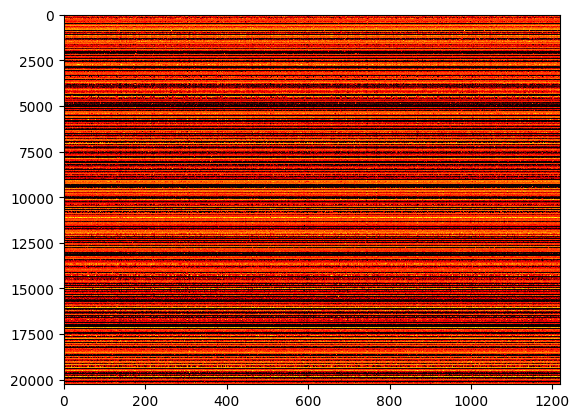

In [15]:
mRNA = raw_mRNA.copy(deep=True)

# Rename first column as 'mRNA ID'
mRNA.rename(columns = {'sample':'mRNA_ID'}, inplace = True)

# Set index as 'mRNA_ID'
mRNA.set_index('mRNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
mRNA.columns.name = 'Sample'

# Fill-NA - 0
mRNA.fillna(0, inplace=True)

# Sampling again
display(mRNA.head())

# Zero features
zero_features = []
for feature in mRNA.index:
    if(np.all(mRNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA have all zero values')

# Drop zero features
mRNA.drop(zero_features, inplace=True, axis=0)

# Final shape
print(f'mRNA shape: {mRNA.shape[0]} mRNAs and {mRNA.shape[1]} samples')

# Heatmap
plt.imshow(mRNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### miRNA

Sample,TCGA-OL-A66H-01,TCGA-3C-AALK-01,TCGA-AR-A1AH-01,TCGA-AC-A5EH-01,TCGA-EW-A2FW-01,TCGA-E9-A1R0-01,TCGA-BH-A0BL-01,TCGA-AR-A1AJ-01,TCGA-A7-A13G-01,TCGA-AC-A62Y-01,...,TCGA-E2-A574-01,TCGA-E2-A1IG-01,TCGA-5L-AAT0-01,TCGA-E9-A1NH-01,TCGA-EW-A6SA-01,TCGA-AR-A24Q-01,TCGA-BH-A1F0-01,TCGA-E9-A1RB-11,TCGA-GM-A4E0-01,TCGA-AC-A5XU-01
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
MIMAT0019868,0.2381,0.0000,0.0,0.0,0.1951,0.0000,0.000,0.4831,0.537604,0.000000,...,0.0,0.0000,0.000000,0.709,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
MIMAT0019869,0.0000,0.2117,0.0,0.0,0.1951,0.6706,0.000,0.0000,0.000000,0.535972,...,0.0,0.0000,0.348594,0.000,0.0000,0.0000,0.7569,0.1298,0.0,0.0000
MIMAT0019860,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.403,0.4831,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000
MIMAT0019862,0.0000,0.0000,0.0,0.0,0.1951,0.0000,0.000,0.0000,0.000000,0.000000,...,0.0,0.4285,0.000000,0.000,0.3034,0.5908,0.7569,0.0000,0.0,0.2444
MIMAT0019863,0.0000,0.0000,0.0,0.0,0.0000,0.0000,0.000,0.0000,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0000


0 features in miRNA have all zero values
miRNA shape: 2238 miRNAs and 832 samples


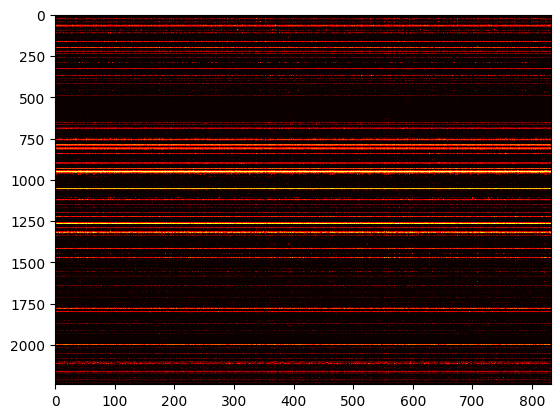

In [16]:
miRNA = raw_miRNA.copy(deep=True)

# Rename first column as 'miRNA ID'
miRNA.rename(columns = {'sample':'miRNA_ID'}, inplace = True)

# Set index as 'miRNA_ID'
miRNA.set_index('miRNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
miRNA.columns.name = 'Sample'

# Fill-NA - 0
miRNA.fillna(0, inplace=True)

# Sampling again
display(miRNA.head())

# Zero features
zero_features = []
for feature in miRNA.index:
    if(np.all(miRNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA have all zero values')

# Drop zero features
miRNA.drop(zero_features, inplace=True, axis=0)

# Final shape
print(f'miRNA shape: {miRNA.shape[0]} miRNAs and {miRNA.shape[1]} samples')

# Heatmap
plt.imshow(miRNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### DNA Methylation

Sample,TCGA-OL-A66H-01,TCGA-3C-AALK-01,TCGA-AC-A5EH-01,TCGA-EW-A2FW-01,TCGA-E9-A1R0-01,TCGA-AR-A1AJ-01,TCGA-AC-A62Y-01,TCGA-E9-A1QZ-01,TCGA-E9-A1R2-01,TCGA-E9-A3X8-01,...,TCGA-BH-A0DI-01,TCGA-E2-A1IG-01,TCGA-E2-A107-01,TCGA-5L-AAT0-01,TCGA-E9-A1NH-01,TCGA-D8-A27E-01,TCGA-AR-A24Q-01,TCGA-BH-A1F0-01,TCGA-E9-A1RB-11,TCGA-AR-A0U0-01
methDNA_ID,,,,,,,,,,,,,,,,,,,,,
cg13332474,0.0192,0.2032,0.3003,0.0287,0.0382,0.0426,0.0240,0.2907,0.0293,0.0300,...,0.0481,0.0263,0.5187,0.0757,0.0458,0.0309,0.0412,0.0452,0.0492,0.0445
cg00651829,0.0179,0.2890,0.0892,0.0234,0.0260,0.0310,0.0228,0.0255,0.0221,0.0258,...,0.0247,0.0166,0.0154,0.0420,0.0262,0.0273,0.0247,0.0214,0.0247,0.0192
cg17027195,0.0367,0.0750,0.0333,0.0460,0.0411,0.1116,0.0386,0.0372,0.0384,0.0423,...,0.0765,0.0415,0.0595,0.0664,0.0370,0.0665,0.0387,0.0663,0.0425,0.0320
cg09868354,0.0655,0.1370,0.0770,0.0688,0.0562,0.0472,0.0874,0.0926,0.0532,0.0570,...,0.0433,0.0483,0.0622,0.1302,0.0495,0.0404,0.0693,0.0739,0.2753,0.0920
cg03050183,0.0748,0.1251,0.6269,0.0947,0.1677,0.0670,0.0712,0.2560,0.0892,0.1996,...,0.5668,0.0813,0.1082,0.1422,0.0986,0.1013,0.0529,0.1042,0.3801,0.3857


Zero features calculation: 100%|██████████| 485577/485577 [00:18<00:00, 25789.41it/s]


89512 features in methDNA have all zero values
methDNA shape: 10480 methDNAs and 888 samples


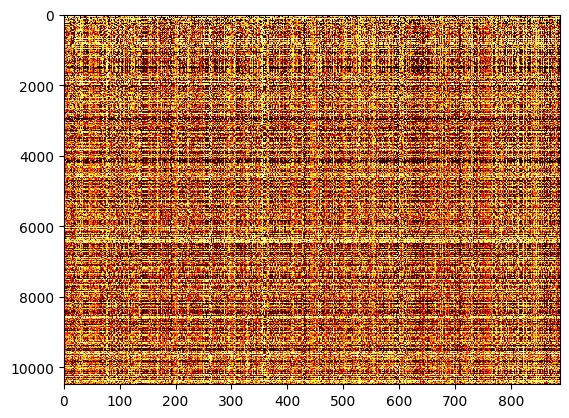

In [17]:
methDNA = raw_methDNA.copy(deep=True)

# Rename first column as 'methDNA ID'
methDNA.rename(columns = {'sample':'methDNA_ID'}, inplace = True)

# Set index as 'methDNA_ID'
methDNA.set_index('methDNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
methDNA.columns.name = 'Sample'

# Fill-NA - 0
methDNA.fillna(0, inplace=True)

# Sampling again
display(methDNA.head())

# Zero features
zero_features = []
for feature in tqdm(methDNA.index, desc='Zero features calculation'):
    if(np.all(methDNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in methDNA have all zero values')

# Drop zero features
methDNA.drop(zero_features, inplace=True, axis=0)

# Top hi-variant features
Ariel = methDNA.var(axis=1).sort_values(ascending=False).head(10480)
methDNA = methDNA.loc[Ariel.index].copy(deep=True)

# Final shape
print(f'methDNA shape: {methDNA.shape[0]} methDNAs and {methDNA.shape[1]} samples')

# Heatmap
plt.imshow(methDNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Bipartite Graph

miRNA_ID,MIMAT0000441,MIMAT0000755,MIMAT0000250,MIMAT0000064,MIMAT0000098,MIMAT0000075,MIMAT0000732,MIMAT0002834,MIMAT0000255,MIMAT0000278,...,MIMAT0002172,MIMAT0000736,MIMAT0000252,MIMAT0000770,MIMAT0001545,MIMAT0000692,MIMAT0000753,MIMAT0000450,MIMAT0000081,MIMAT0000281
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
ARF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M6PR,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
FKBP4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CYP26B1,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
FUCA2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bipart shape: 11329 mRNAs and 279 miRNAs


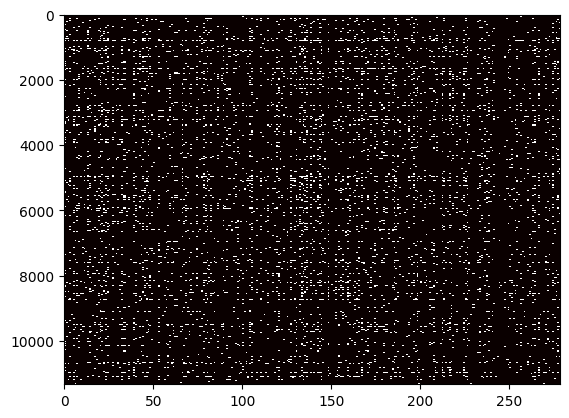

In [18]:
bipart = raw_bipart_data.copy(deep=True)

# Rename first column ('gene_name') as 'mRNA ID'
bipart.rename(columns = {'gene_name':'mRNA_ID'}, inplace = True)

# Set index as 'mRNA_ID'
bipart.set_index('mRNA_ID', inplace = True)

# Rename the 'columns' row as 'miRNA_ID'
bipart.columns.name = 'miRNA_ID'

# Sampling again
display(bipart.head())

# Final shape
print(f'Bipart shape: {bipart.shape[0]} mRNAs and {bipart.shape[1]} miRNAs')

# Heatmap
plt.imshow(bipart, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Clinical Data

In [4]:
clinical = raw_clinical.copy(deep=True)

# Rename first column as 'Sample'
clinical.rename(columns = {'Unnamed: 0':'Sample'}, inplace = True)

# Set index as 'Sample'
clinical.set_index('Sample', inplace = True)

# Display
display(clinical.head())

# Final shape
print(f'Clinical shape: {clinical.shape[0]} samples and {clinical.shape[1]} features as {list(clinical.columns)}')

,ER,HER2,PR,TN
Sample,,,,
TCGA-5T-A9QA-01,Positive,Negative,Negative,Negative
TCGA-A1-A0SE-01,Positive,Negative,Positive,Negative
TCGA-A1-A0SH-01,Negative,Negative,Positive,Negative
TCGA-A1-A0SJ-01,Positive,Negative,Positive,Negative
TCGA-A1-A0SM-01,Positive,Positive,Negative,Negative


Clinical shape: 412 samples and 4 features as ['ER', 'HER2', 'PR', 'TN']


### Survival/Progression Data

In [13]:
survival = raw_survival[[
    'Sample ID',
    'Disease Free (Months)',
    'Disease Free Status',
    'Overall Survival (Months)',
    'Overall Survival Status',
]].copy(deep=True)

# Rename first column as 'Sample'
survival.rename(columns = {'Sample ID':'Sample'}, inplace = True)

# Set index as 'Sample'
survival.set_index('Sample', inplace = True)

# Display
display(survival.head())

# Final shape
print(f'Survival shape: {survival.shape[0]} samples and {survival.shape[1]} features as {list(survival.columns)}')

,Disease Free (Months),Disease Free Status,Overall Survival (Months),Overall Survival Status
Sample,,,,
TCGA-3C-AAAU-01,59.40,1:Recurred/Progressed,132.95,0:LIVING
TCGA-3C-AALI-01,131.57,0:DiseaseFree,131.57,0:LIVING
TCGA-3C-AALJ-01,48.42,0:DiseaseFree,48.42,0:LIVING
TCGA-3C-AALK-01,47.57,0:DiseaseFree,47.57,0:LIVING
TCGA-4H-AAAK-01,11.43,0:DiseaseFree,11.43,0:LIVING


Survival shape: 1108 samples and 4 features as ['Disease Free (Months)', 'Disease Free Status', 'Overall Survival (Months)', 'Overall Survival Status']


,Disease Free (Months),Disease Free Status,ER,HER2,Overall Survival (Months),Overall Survival Status,PR,TN
Sample,,,,,,,,
TCGA-5T-A9QA-01,9.95,0:DiseaseFree,Positive,Negative,9.95,0:LIVING,Negative,Negative
TCGA-A1-A0SE-01,43.40,0:DiseaseFree,Positive,Negative,43.40,0:LIVING,Positive,Negative
TCGA-A1-A0SH-01,47.21,0:DiseaseFree,Negative,Negative,47.21,0:LIVING,Positive,Negative
TCGA-A1-A0SJ-01,13.67,0:DiseaseFree,Positive,Negative,13.67,0:LIVING,Positive,Negative
TCGA-A1-A0SM-01,7.95,0:DiseaseFree,Positive,Positive,7.95,0:LIVING,Negative,Negative


,ER,HER2,PR,TN
Sample,,,,
TCGA-5T-A9QA-01,Positive,Negative,Negative,Negative
TCGA-A1-A0SE-01,Positive,Negative,Positive,Negative
TCGA-A1-A0SH-01,Negative,Negative,Positive,Negative
TCGA-A1-A0SJ-01,Positive,Negative,Positive,Negative
TCGA-A1-A0SM-01,Positive,Positive,Negative,Negative


412
412
1108


# Aggregating, Label Engineering & Saving Data

In [21]:
# Sample again all data
display(f'mRNA shape: {mRNA.shape[0]} mRNAs and {mRNA.shape[1]} samples')
# display(mRNA.head())


display(f'miRNA shape: {miRNA.shape[0]} miRNAs and {miRNA.shape[1]} samples')
# display(miRNA.head())


display(f'methDNA shape: {methDNA.shape[0]} methDNAs and {methDNA.shape[1]} samples')
# display(methDNA.head())


display(f'Bipart shape: {bipart.shape[0]} mRNAs and {bipart.shape[1]} miRNAs')
# display(bipart.head())


display(f'Clinical shape: {clinical.shape[0]} samples and {clinical.shape[1]} features as {list(clinical.columns)}')
# display(clinical.head())


display(f'Survival shape: {survival.shape[0]} samples and {survival.shape[1]} features as {list(survival.columns)}')
# display(survival.head())

'mRNA shape: 20252 mRNAs and 1218 samples'

'miRNA shape: 2238 miRNAs and 832 samples'

'methDNA shape: 10480 methDNAs and 888 samples'

'Bipart shape: 11329 mRNAs and 279 miRNAs'

"Clinical shape: 412 samples and 4 features as ['ER', 'HER2', 'PR', 'TN']"

"Survival shape: 1108 samples and 4 features as ['Disease Free (Months)', 'Disease Free Status', 'Overall Survival (Months)', 'Overall Survival Status']"

### 2-omic: mRNA and miRNA

In [22]:
common_samples_2omics = list(set(mRNA.columns) & set(miRNA.columns))
print(f'Common samples: {len(common_samples_2omics)} - {list(common_samples_2omics)}')
print(f'% of common samples wrt mRNA: {len(common_samples_2omics) / len(mRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt miRNA: {len(common_samples_2omics) / len(miRNA.columns) * 100:.2f}%')
print('\n')

common_mRNAs = list(set(mRNA.index) & set(bipart.index))
print(f'Common mRNAs: {len(common_mRNAs)} - {list(common_mRNAs)}')
print(f'% of common mRNAs wrt mRNA: {len(common_mRNAs) / len(mRNA.index) * 100:.2f}%')
print(f'% of common mRNAs wrt bipart: {len(common_mRNAs) / len(bipart.index) * 100:.2f}%')
print('\n')

common_miRNAs = list(set(miRNA.index) & set(bipart.columns))
print(f'Common miRNAs: {len(common_miRNAs)} - {list(common_miRNAs)}')
print(f'% of common miRNAs wrt miRNA: {len(common_miRNAs) / len(miRNA.index) * 100:.2f}%')
print(f'% of common miRNAs wrt bipart: {len(common_miRNAs) / len(bipart.columns) * 100:.2f}%')

Common samples: 830 - ['TCGA-E9-A1NG-01', 'TCGA-A2-A4S2-01', 'TCGA-BH-A28O-01', 'TCGA-A7-A6VY-01', 'TCGA-E9-A3QA-01', 'TCGA-BH-A0EI-01', 'TCGA-E2-A1IL-01', 'TCGA-E2-A1II-01', 'TCGA-EW-A1J3-01', 'TCGA-A7-A4SD-01', 'TCGA-BH-A0DV-11', 'TCGA-BH-A1EW-11', 'TCGA-AC-A8OR-01', 'TCGA-E9-A22E-01', 'TCGA-LL-A8F5-01', 'TCGA-AR-A1AI-01', 'TCGA-E2-A152-01', 'TCGA-BH-A1FE-11', 'TCGA-B6-A1KN-01', 'TCGA-BH-A28Q-01', 'TCGA-D8-A1J9-01', 'TCGA-OL-A5RV-01', 'TCGA-A2-A3Y0-01', 'TCGA-AC-A2FB-01', 'TCGA-D8-A27E-01', 'TCGA-BH-A0HN-01', 'TCGA-E2-A14R-01', 'TCGA-BH-A1EY-01', 'TCGA-JL-A3YX-01', 'TCGA-D8-A1JE-01', 'TCGA-BH-A209-11', 'TCGA-A1-A0SI-01', 'TCGA-E2-A3DX-01', 'TCGA-C8-A8HP-01', 'TCGA-E2-A15K-11', 'TCGA-E9-A249-01', 'TCGA-AN-A0AT-01', 'TCGA-LL-A6FP-01', 'TCGA-C8-A1HF-01', 'TCGA-A2-A1FZ-01', 'TCGA-BH-A1FB-11', 'TCGA-E2-A1LL-01', 'TCGA-C8-A12X-01', 'TCGA-E9-A54X-01', 'TCGA-A7-A3IY-01', 'TCGA-D8-A27V-01', 'TCGA-BH-A0DI-01', 'TCGA-A2-A25A-01', 'TCGA-AO-A12D-01', 'TCGA-PL-A8LV-01', 'TCGA-AC-A8OP-01', 'TCGA-LL

In [23]:
# Sort the indexes
common_samples_2omics.sort()
common_mRNAs.sort()
common_miRNAs.sort()

# Align the data
mRNA_common = mRNA.loc[common_mRNAs, common_samples_2omics].copy(deep=True)
miRNA_common = miRNA.loc[common_miRNAs, common_samples_2omics].copy(deep=True)
bipart_common = bipart.loc[common_mRNAs, common_miRNAs].copy(deep=True)


# Zero features for mRNA_common
zero_features = []
for feature in mRNA_common.index:
    if(np.all(mRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA_common have all zero values')

# Zero features for miRNA_common
zero_features = []
for feature in miRNA_common.index:
    if(np.all(miRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA_common have all zero values')




display(f'Common mRNA shape: {mRNA_common.shape[0]} mRNAs and {mRNA_common.shape[1]} samples')
# display(mRNA_common.head())

display(f'Common miRNA shape: {miRNA_common.shape[0]} miRNAs and {miRNA_common.shape[1]} samples')
# display(miRNA_common.head())

display(f'Common bipart shape: {bipart_common.shape[0]} mRNAs and {bipart_common.shape[1]} miRNAs')
# display(bipart_common.head())


0 features in mRNA_common have all zero values
0 features in miRNA_common have all zero values


'Common mRNA shape: 10480 mRNAs and 830 samples'

'Common miRNA shape: 277 miRNAs and 830 samples'

'Common bipart shape: 10480 mRNAs and 277 miRNAs'

In [24]:
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA'):
        s3.makedirs(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA')
    if not s3.exists(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA'):
        s3.makedirs(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA')
else:
    if not os.path.exists(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA'):
        os.makedirs(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA')
    if not os.path.exists(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA'):
        os.makedirs(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA')

if OVERRIDE_EXISTING_2_OMICS:
    mRNA_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/mRNA.parquet', storage_options=storage_options)
    miRNA_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/miRNA.parquet', storage_options=storage_options)
    bipart_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/bipart.parquet', storage_options=storage_options)
    clinical.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/clinical.parquet', storage_options=storage_options)
survival.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/survival.parquet', storage_options=storage_options)

In [25]:
import random
from sklearn.model_selection import train_test_split
common_samples_2omics_for_clinical = list(set(common_samples_2omics) & set(clinical.index))
clinical_common_2omics = clinical.loc[common_samples_2omics_for_clinical].copy(deep=True)
clinical_common_2omics.replace({'Positive': 1, 'Negative': 0}, inplace=True)


print(f'Common samples eligible for threshold engineering: {len(clinical_common_2omics)}')
display(clinical_common_2omics.head())



test_index = [f'Test{i:03}' for i in range(TEST_PASS)]
for label in ['ER', 'PR', 'HER2', 'TN']:
    clinical_testdata = pd.DataFrame(
        index = test_index,
        columns = ['train_sample_ids', 'test_sample_ids', 'train_ground_truth', 'test_ground_truth']
    )
    positive_samples = list(clinical_common_2omics[clinical_common_2omics[label] == 1].index)
    negative_samples = list(clinical_common_2omics[clinical_common_2omics[label] == 0].index)

    print(f'Label: {label}')
    print(f'Positive samples: {len(positive_samples)}')
    print(f'Negative samples: {len(negative_samples)}')

    label_dict = {s:1 for s in positive_samples}
    label_dict.update({s:0 for s in negative_samples}) 
    for test_pass in tqdm(range(TEST_PASS), desc=f'Building testcases for {label}'):
        pos_train_idx, pos_test_idx = train_test_split(positive_samples, test_size=0.2)
        neg_train_idx, neg_test_idx = train_test_split(negative_samples, test_size=0.2)

        train_idx = pos_train_idx + neg_train_idx
        test_idx = pos_test_idx + neg_test_idx
        random.shuffle(train_idx)
        random.shuffle(test_idx)

        clinical_testdata.loc[f'Test{test_pass:03}', 'train_sample_ids'] = train_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_sample_ids'] = test_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'train_ground_truth'] = [label_dict[s] for s in train_idx]
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_ground_truth'] = [label_dict[s] for s in test_idx]
    
    
    # if OVERRIDE_EXISTING_2_OMICS:
    #     clinical_testdata.to_parquet(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA/{label}.parquet', storage_options=storage_options)



Common samples eligible for threshold engineering: 239


/tmp/ipykernel_263624/345003507.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_common_2omics.replace({'Positive': 1, 'Negative': 0}, inplace=True)


,ER,HER2,PR,TN
Sample,,,,
TCGA-AC-A23C-01,1,1,1,0
TCGA-E2-A2P5-01,1,0,1,0
TCGA-OL-A5RW-01,0,0,0,1
TCGA-OL-A5RX-01,1,0,1,0
TCGA-AQ-A1H2-01,1,1,1,0


Label: ER
Positive samples: 185
Negative samples: 54


Building testcases for ER: 100%|██████████| 100/100 [00:00<00:00, 1622.08it/s]


Label: HER2
Positive samples: 39
Negative samples: 200


Building testcases for HER2: 100%|██████████| 100/100 [00:00<00:00, 1610.70it/s]


Label: PR
Positive samples: 159
Negative samples: 80


Building testcases for PR: 100%|██████████| 100/100 [00:00<00:00, 1666.64it/s]


Label: TN
Positive samples: 46
Negative samples: 193


Building testcases for TN: 100%|██████████| 100/100 [00:00<00:00, 1659.10it/s]


### 3-omic: mRNA, miRNA, and DNA methylation

In [26]:
common_samples_3omics = list(set(mRNA.columns) & set(miRNA.columns) & set(methDNA.columns))
print(f'Common samples: {len(common_samples_3omics)} - {list(common_samples_2omics)}')
print(f'% of common samples wrt mRNA: {len(common_samples_3omics) / len(mRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt miRNA: {len(common_samples_3omics) / len(miRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt methDNA: {len(common_samples_3omics) / len(methDNA.columns) * 100:.2f}%')
print(f'% of common samples wrt 2-omics: {len(common_samples_3omics) / len(common_samples_2omics) * 100:.2f}%')
print('\n')

common_mRNAs = list(set(mRNA.index) & set(bipart.index))
print(f'Common mRNAs: {len(common_mRNAs)} - {list(common_mRNAs)}')
print(f'% of common mRNAs wrt mRNA: {len(common_mRNAs) / len(mRNA.index) * 100:.2f}%')
print(f'% of common mRNAs wrt bipart: {len(common_mRNAs) / len(bipart.index) * 100:.2f}%')
print('\n')

common_miRNAs = list(set(miRNA.index) & set(bipart.columns))
print(f'Common miRNAs: {len(common_miRNAs)} - {list(common_miRNAs)}')
print(f'% of common miRNAs wrt miRNA: {len(common_miRNAs) / len(miRNA.index) * 100:.2f}%')
print(f'% of common miRNAs wrt bipart: {len(common_miRNAs) / len(bipart.columns) * 100:.2f}%')

Common samples: 674 - ['TCGA-3C-AAAU-01', 'TCGA-3C-AALI-01', 'TCGA-3C-AALJ-01', 'TCGA-3C-AALK-01', 'TCGA-4H-AAAK-01', 'TCGA-5L-AAT0-01', 'TCGA-5T-A9QA-01', 'TCGA-A1-A0SB-01', 'TCGA-A1-A0SD-01', 'TCGA-A1-A0SF-01', 'TCGA-A1-A0SG-01', 'TCGA-A1-A0SI-01', 'TCGA-A1-A0SN-01', 'TCGA-A1-A0SQ-01', 'TCGA-A2-A04N-01', 'TCGA-A2-A04U-01', 'TCGA-A2-A04W-01', 'TCGA-A2-A0CK-01', 'TCGA-A2-A0CL-01', 'TCGA-A2-A0CO-01', 'TCGA-A2-A0CR-01', 'TCGA-A2-A0CS-01', 'TCGA-A2-A0CV-01', 'TCGA-A2-A0CW-01', 'TCGA-A2-A0D3-01', 'TCGA-A2-A0EP-01', 'TCGA-A2-A0ES-01', 'TCGA-A2-A0EW-01', 'TCGA-A2-A0T3-01', 'TCGA-A2-A1FV-01', 'TCGA-A2-A1FW-01', 'TCGA-A2-A1FX-01', 'TCGA-A2-A1FZ-01', 'TCGA-A2-A1G0-01', 'TCGA-A2-A1G1-01', 'TCGA-A2-A1G4-01', 'TCGA-A2-A1G6-01', 'TCGA-A2-A259-01', 'TCGA-A2-A25A-01', 'TCGA-A2-A25B-01', 'TCGA-A2-A25C-01', 'TCGA-A2-A25D-01', 'TCGA-A2-A25E-01', 'TCGA-A2-A25F-01', 'TCGA-A2-A3KC-01', 'TCGA-A2-A3KD-01', 'TCGA-A2-A3XS-01', 'TCGA-A2-A3XT-01', 'TCGA-A2-A3XU-01', 'TCGA-A2-A3XV-01', 'TCGA-A2-A3XW-01', 'TCGA-A2

In [27]:
# Sort the indexes
common_samples_3omics.sort()
common_mRNAs.sort()
common_miRNAs.sort()

# Align the data
mRNA_common = mRNA.loc[common_mRNAs, common_samples_3omics].copy(deep=True)
miRNA_common = miRNA.loc[common_miRNAs, common_samples_3omics].copy(deep=True)
methDNA_common = methDNA.loc[:, common_samples_3omics].copy(deep=True)
bipart_common = bipart.loc[common_mRNAs, common_miRNAs].copy(deep=True)


# Zero features for mRNA_common
zero_features = []
for feature in mRNA_common.index:
    if(np.all(mRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA_common have all zero values')

# Zero features for miRNA_common
zero_features = []
for feature in miRNA_common.index:
    if(np.all(miRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA_common have all zero values')

# Zero features for methDNA_common
zero_features = []
for feature in methDNA_common.index:
    if(np.all(methDNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in methDNA_common have all zero values')



display(f'Common mRNA shape: {mRNA_common.shape[0]} mRNAs and {mRNA_common.shape[1]} samples')
# display(mRNA_common.head())

display(f'Common miRNA shape: {miRNA_common.shape[0]} miRNAs and {miRNA_common.shape[1]} samples')
# display(miRNA_common.head())

display(f'Common methDNA shape: {methDNA_common.shape[0]} methDNAs and {methDNA_common.shape[1]} samples')
# display(methDNA_common.head())

display(f'Common bipart shape: {bipart_common.shape[0]} mRNAs and {bipart_common.shape[1]} miRNAs')
# display(bipart_common.head())



0 features in mRNA_common have all zero values
0 features in miRNA_common have all zero values
0 features in methDNA_common have all zero values


'Common mRNA shape: 10480 mRNAs and 674 samples'

'Common miRNA shape: 277 miRNAs and 674 samples'

'Common methDNA shape: 10480 methDNAs and 674 samples'

'Common bipart shape: 10480 mRNAs and 277 miRNAs'

In [28]:
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA'):
        s3.makedirs(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA')
    if not s3.exists(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA'):
        s3.makedirs(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA')
    
else:
    if not os.path.exists(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA'):
        os.makedirs(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA')
    if not os.path.exists(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA'):
        os.makedirs(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA')
    


if OVERRIDE_EXISTING_3_OMICS:
    mRNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/mRNA.parquet', storage_options=storage_options)
    miRNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/miRNA.parquet', storage_options=storage_options)
    methDNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/methDNA.parquet', storage_options=storage_options)
    bipart_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/bipart.parquet', storage_options=storage_options)
    clinical.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/clinical.parquet', storage_options=storage_options)
survival.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/survival.parquet', storage_options=storage_options)



In [29]:
import random
from sklearn.model_selection import train_test_split
common_samples_3omics_for_clinical = list(set(common_samples_3omics) & set(clinical.index))
clinical_common_3omics = clinical.loc[common_samples_3omics_for_clinical].copy(deep=True)

clinical_common_3omics.replace({'Positive': 1, 'Negative': 0}, inplace=True)

print(f'Common samples eligible for threshold engineering: {len(clinical_common_3omics)}')
display(clinical_common_3omics.head())


test_index = [f'Test{i:03}' for i in range(TEST_PASS)]
for label in ['ER', 'PR', 'HER2', 'TN']:
    clinical_testdata = pd.DataFrame(
        index = test_index,
        columns = ['train_sample_ids', 'test_sample_ids', 'train_ground_truth', 'test_ground_truth']
    )
    positive_samples = list(clinical_common_3omics[clinical_common_3omics[label] == 1].index)
    negative_samples = list(clinical_common_3omics[clinical_common_3omics[label] == 0].index)

    print(f'Label: {label}')
    print(f'Positive samples: {len(positive_samples)}')
    print(f'Negative samples: {len(negative_samples)}')

    label_dict = {s:1 for s in positive_samples}
    label_dict.update({s:0 for s in negative_samples}) 
    for test_pass in tqdm(range(TEST_PASS), desc=f'Building testcases for {label}'):
        pos_train_idx, pos_test_idx = train_test_split(positive_samples, test_size=0.2)
        neg_train_idx, neg_test_idx = train_test_split(negative_samples, test_size=0.2)

        train_idx = pos_train_idx + neg_train_idx
        test_idx = pos_test_idx + neg_test_idx
        random.shuffle(train_idx)
        random.shuffle(test_idx)

        clinical_testdata.loc[f'Test{test_pass:03}', 'train_sample_ids'] = train_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_sample_ids'] = test_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'train_ground_truth'] = [label_dict[s] for s in train_idx]
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_ground_truth'] = [label_dict[s] for s in test_idx]


    if OVERRIDE_EXISTING_3_OMICS:
        clinical_testdata.to_parquet(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA/{label}.parquet', storage_options=storage_options)


Common samples eligible for threshold engineering: 198


/tmp/ipykernel_263624/452241415.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  clinical_common_3omics.replace({'Positive': 1, 'Negative': 0}, inplace=True)


,ER,HER2,PR,TN
Sample,,,,
TCGA-AC-A23C-01,1,1,1,0
TCGA-E2-A2P5-01,1,0,1,0
TCGA-OL-A5RW-01,0,0,0,1
TCGA-OL-A5RX-01,1,0,1,0
TCGA-AQ-A1H2-01,1,1,1,0


Label: ER
Positive samples: 153
Negative samples: 45


Building testcases for ER: 100%|██████████| 100/100 [00:00<00:00, 1550.36it/s]


Label: HER2
Positive samples: 28
Negative samples: 170


Building testcases for HER2: 100%|██████████| 100/100 [00:00<00:00, 1715.68it/s]


Label: PR
Positive samples: 130
Negative samples: 68


Building testcases for PR: 100%|██████████| 100/100 [00:00<00:00, 1307.34it/s]


Label: TN
Positive samples: 40
Negative samples: 158


Building testcases for TN: 100%|██████████| 100/100 [00:00<00:00, 1713.22it/s]


# Mini Dataset

In [30]:
mini_dataset_mRNA_feature_size = 50
mini_dataset_miRNA_feature_size = 50
mini_dataset_methDNA_feature_size = 50
mini_dataset_samples_size = 50
folder = 'processed_micro'


mRNA_common = pd.read_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/mRNA.parquet', storage_options=storage_options)
miRNA_common = pd.read_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/miRNA.parquet', storage_options=storage_options)
methDNA_common = pd.read_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/methDNA.parquet', storage_options=storage_options)
bipart_common = pd.read_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/bipart.parquet', storage_options=storage_options)
clinical = pd.read_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/clinical.parquet', storage_options=storage_options)

common_sample = list(set(mRNA_common.columns).intersection(miRNA_common.columns).intersection(clinical.index))
clinical_common = clinical.loc[common_sample, :].copy(deep=True)

import random

mini_mRNA = sorted(list(set(random.sample(mRNA_common.index.to_list(), k = mini_dataset_mRNA_feature_size))))
mini_miRNA = sorted(list(set(random.sample(miRNA_common.index.to_list(), k = mini_dataset_miRNA_feature_size))))
mini_methDNA = sorted(list(set(random.sample(methDNA_common.index.to_list(), k = mini_dataset_methDNA_feature_size))))
mini_samples = sorted(list(set(random.sample(list(common_sample), k = mini_dataset_samples_size))))

mRNA_mini = mRNA_common.loc[mini_mRNA, mini_samples].copy(deep=True)
miRNA_mini = miRNA_common.loc[mini_miRNA, mini_samples].copy(deep=True)
methDNA_mini = methDNA_common.loc[mini_methDNA, mini_samples].copy(deep=True)
bipart_mini = bipart_common.loc[mini_mRNA, mini_miRNA].copy(deep=True)



# Zero features for mRNA_mini
zero_features = []
for feature in mRNA_mini.index:
    if(np.all(mRNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
mRNA_mini.drop(zero_features, inplace=True, axis=0)
bipart_mini.drop(zero_features, inplace=True, axis=0)
print(f'{len(zero_features)} features in mRNA_mini have all zero values')

# Zero features for miRNA_mini
zero_features = []
for feature in miRNA_mini.index:
    if(np.all(miRNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
miRNA_mini.drop(zero_features, inplace=True, axis=0)
bipart_mini.drop(zero_features, inplace=True, axis=1)
print(f'{len(zero_features)} features in miRNA_mini have all zero values')

# Zero features for methDNA_mini
zero_features = []
for feature in methDNA_mini.index:
    if(np.all(methDNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
methDNA_mini.drop(zero_features, inplace=True, axis=0)
print(f'{len(zero_features)} features in methDNA_mini have all zero values')



if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/{folder}'):
        s3.makedirs(f'{DATA_PATH}/{folder}')
else:
    if not os.path.exists(f'{DATA_PATH}/{folder}'):
        os.makedirs(f'{DATA_PATH}/{folder}')

mRNA_mini.to_parquet(f'{DATA_PATH}/{folder}/mRNA.parquet', storage_options=storage_options)
miRNA_mini.to_parquet(f'{DATA_PATH}/{folder}/miRNA.parquet', storage_options=storage_options)
bipart_mini.to_parquet(f'{DATA_PATH}/{folder}/bipart.parquet', storage_options=storage_options)
methDNA_mini.to_parquet(f'{DATA_PATH}/{folder}/methDNA.parquet', storage_options=storage_options)

0 features in mRNA_mini have all zero values
1 features in miRNA_mini have all zero values
0 features in methDNA_mini have all zero values
